# BLE Proximity Experiment - Multi-Layered Perceptron Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [2]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

Using TensorFlow backend.
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarn

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [3]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [4]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [5]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,0-1 meters,0.0
1,0.0,0.0,-46,-46.500000,0-1 meters,0.0
2,0.0,0.0,-46,-46.333333,0-1 meters,0.0
3,0.0,0.0,-47,-46.500000,0-1 meters,0.0
4,0.0,0.0,-47,-46.600000,0-1 meters,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,3-4 meters,3.5
12471,0.0,3.5,-87,-84.684211,3-4 meters,3.5
12472,0.0,3.5,-87,-84.800000,3-4 meters,3.5
12473,0.0,3.5,-87,-84.904762,3-4 meters,3.5


(12475, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,3-4 meters,3.5
411,0.0,3.5,-88,-84.500000,3-4 meters,3.5
412,0.0,3.5,-84,-84.428571,3-4 meters,3.5
413,0.0,3.5,-83,-84.250000,3-4 meters,3.5


(415, 6)

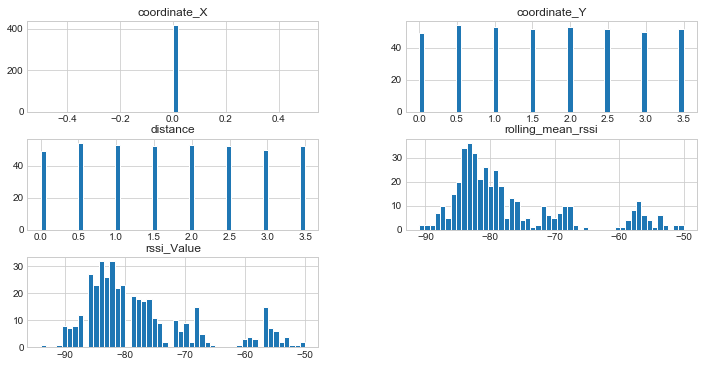

In [6]:
test_dataset = load_file('../../distance_proximity_experiments-checkpoint.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (My Device)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,0-1 meters,0.0
1,0.0,0.0,-44,-44.000000,0-1 meters,0.0
2,0.0,0.0,-44,-44.000000,0-1 meters,0.0
3,0.0,0.0,-44,-44.000000,0-1 meters,0.0
4,0.0,0.0,-45,-44.200000,0-1 meters,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,3-4 meters,3.5
2280,0.0,3.5,-85,-84.000000,3-4 meters,3.5
2281,0.0,3.5,-85,-84.050000,3-4 meters,3.5
2282,0.0,3.5,-92,-84.428571,3-4 meters,3.5


(2284, 6)

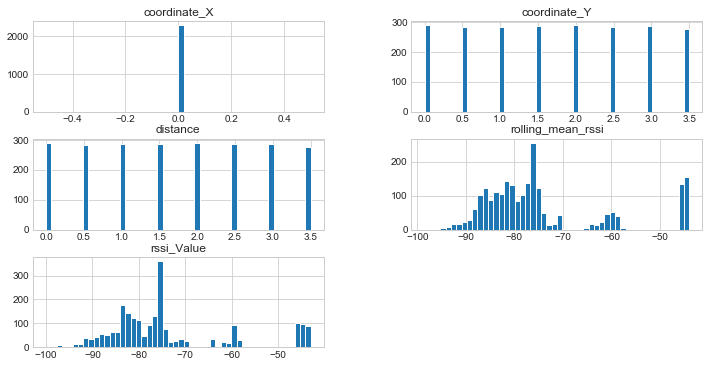

In [7]:
test_dataset_my_device = load_file('../../dataset_test.csv')
positions = test_dataset_my_device['coordinate_Y']
test_dataset_my_device['distance'] = positions
replace_features_nan(test_dataset_my_device)
display(test_dataset_my_device)
display(test_dataset_my_device.shape)
test_dataset_my_device.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [8]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12475 entries, 0 to 12474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       12475 non-null  float64
 1   coordinate_Y       12475 non-null  float64
 2   rssi_Value         12475 non-null  int64  
 3   rolling_mean_rssi  12475 non-null  float64
 4   zone               12475 non-null  object 
 5   distance           12475 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 584.9+ KB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [9]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,12475.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0
coordinate_Y,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5
rssi_Value,12475.0,-73.416754,12.929039,-102.0,-82.0,-76.000000,-64.00,-45.0
rolling_mean_rssi,12475.0,-73.454044,12.766312,-98.5,-82.2,-76.285714,-63.75,-46.0
distance,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5


### % of Missing Values

In [10]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [11]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

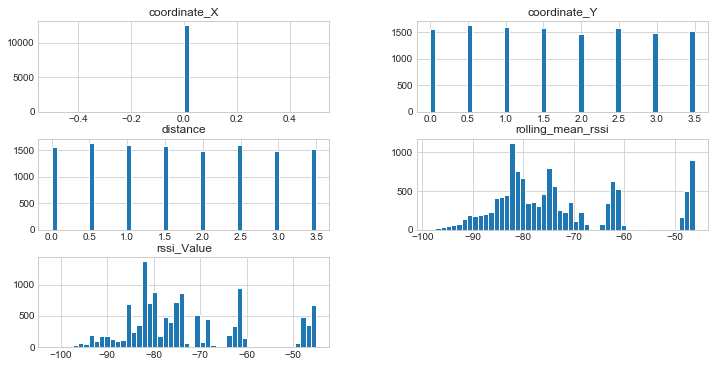

In [12]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

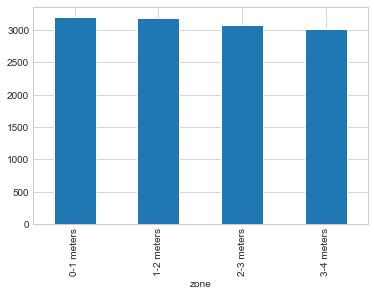

In [13]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

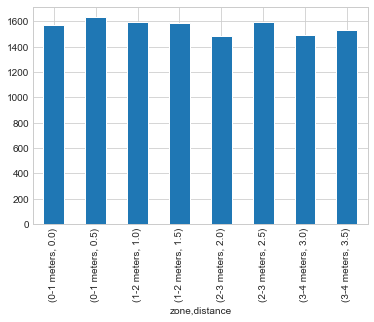

In [14]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

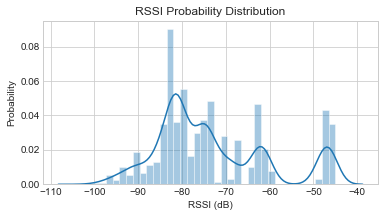

In [15]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

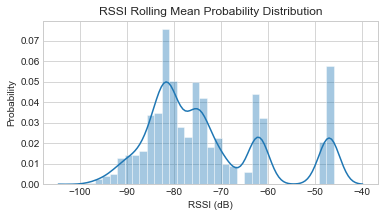

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

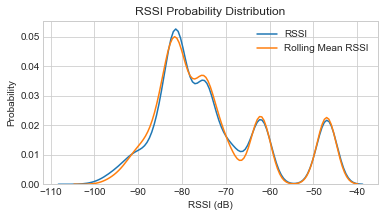

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [18]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.864615,-0.873980,1.000000
rssi_Value,NaN,-0.864615,1.000000,0.981441,-0.864615
rolling_mean_rssi,NaN,-0.873980,0.981441,1.000000,-0.873980
distance,NaN,1.000000,-0.864615,-0.873980,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.864615
rolling_mean_rssi   -0.873980
coordinate_X              NaN
Name: distance, dtype: float64

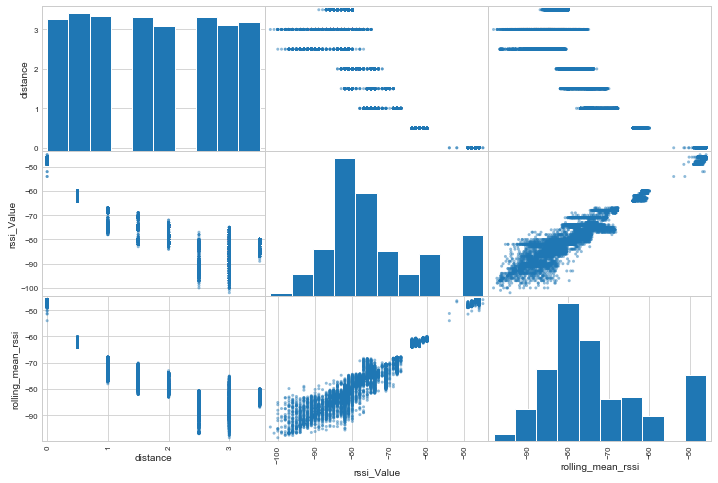

In [19]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [20]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [21]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_my_device,'rssi_Value')
compute_data_cleaning(test_dataset_my_device,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [22]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [23]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
12470,3-4 meters
12471,3-4 meters
12472,3-4 meters
12473,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0],
       [0],
       [0],
       ...,
       [3],
       [3],
       [3]])

In [24]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
410,3-4 meters
411,3-4 meters
412,3-4 meters
413,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(415, 1)

In [25]:
categorical_zone = test_dataset_my_device[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_my_device['labels'] = test_changed
test_Y_my_device = test_dataset_my_device['labels'].values.reshape(-1,1)
display(test_Y_my_device.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
2279,3-4 meters
2280,3-4 meters
2281,3-4 meters
2282,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2284, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [26]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [27]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-54.656250,-54.714171
1-2 meters,-73.941824,-73.986266
2-3 meters,-81.840872,-81.883638
3-4 meters,-84.163468,-84.165817


### Plot Training Data
Graphical Display of the observations in the dataset

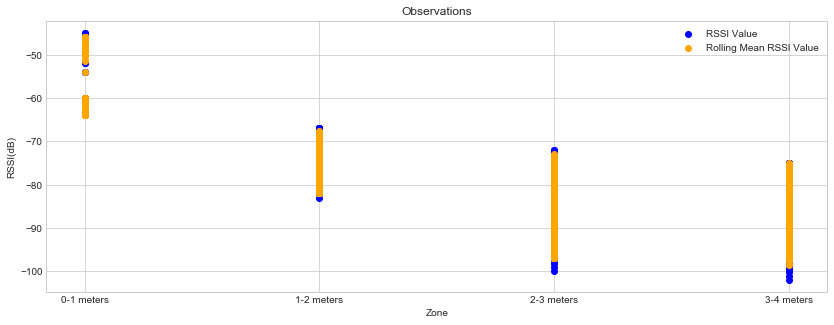

In [28]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [29]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(415, 1)

(415, 1)

(415, 2)

In [30]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-63.223301,-63.123000
1-2 meters,-79.533333,-79.841372
2-3 meters,-82.171429,-81.838530
3-4 meters,-84.215686,-83.930766


In [31]:
test_X_rssi_my_device = pd.DataFrame(test_dataset_my_device['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_my_device.shape)
test_X_rolling_mean_my_device = pd.DataFrame(test_dataset_my_device['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_my_device.shape)
test_combination_features_X_my_device = test_dataset_my_device[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_my_device.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [32]:
data_plot_means = test_dataset_my_device.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-55.246503,-55.259603
1-2 meters,-78.954545,-79.459584
2-3 meters,-77.871080,-77.982160
3-4 meters,-85.335689,-85.247963


### Plot Test Data

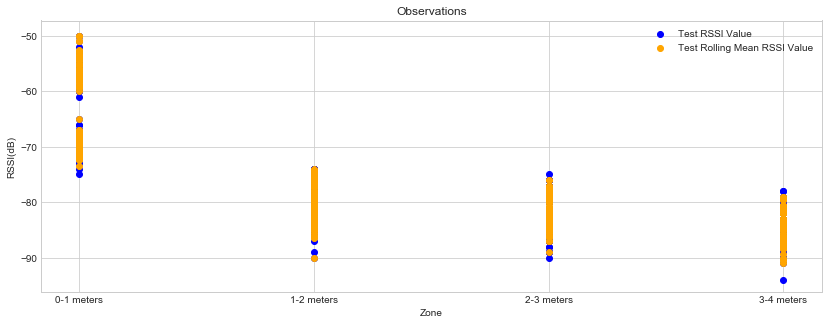

In [33]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

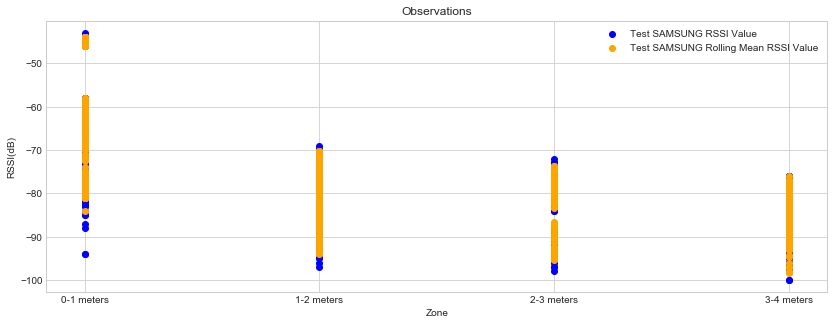

In [34]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [35]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Batch size of samples
batch_size = [10, 20, 40, 60, 80, 100]
# Epochs 
epochs = [10, 50, 100]
# Optimization function
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# Learning Rate - only used with SGD optimizer
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# Momentum - only used with SGD optimizer
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# Activation Function
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# Number of neurons in a hidden layer
neurons = [100,300,400,500,600]

### Statistics Output Format

In [36]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.45858187, 0.54141813])

rolling_mean_rssi    0.541418
rssi_Value           0.458582
dtype: float64

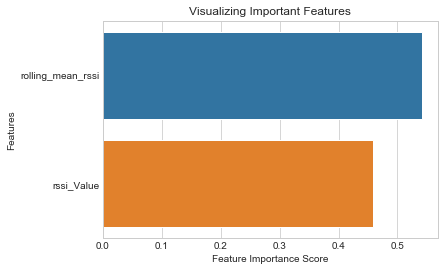

In [37]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - MLP Classification Model
Experiments with MLP algorithm

In [38]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = create_model()
display(model.summary())

Default number of neurons: 180
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180)               540       
_________________________________________________________________
dense_2 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 724       
Total params: 33,844
Trainable params: 33,844
Non-trainable params: 0
_________________________________________________________________


None

In [39]:
def compute_MLP_Classifier(flag=0,dim=2,
                              trainX_data = None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,batch_size=10,epochs=50,verbose=0,num_neurons=180,optimizer_func='adam',activation_func='relu'):
    keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,epochs=epochs,num_neurons=num_neurons,optimizer=optimizer_func,activation=activation_func,batch_size=batch_size,verbose=verbose)
    seed = 7
    np.random.seed(seed)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,keras_classification_model)
    else:
        main_estimator = keras_classification_model
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        print("Cross Validation Activated. CV = " + str(cross_validation))
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(dataset.zone,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

#### Check Training model with no cross validation

Epoch 1/50
12475/12475 [==============================] - 2s 144us/step - loss: 0.5908 - accuracy: 0.6885
Epoch 2/50
12475/12475 [==============================] - 2s 140us/step - loss: 0.5401 - accuracy: 0.6954
Epoch 3/50
12475/12475 [==============================] - 2s 170us/step - loss: 0.5321 - accuracy: 0.6940
Epoch 4/50
12475/12475 [==============================] - 3s 202us/step - loss: 0.5262 - accuracy: 0.6860
Epoch 5/50
12475/12475 [==============================] - 2s 191us/step - loss: 0.5159 - accuracy: 0.6983
Epoch 6/50
12475/12475 [==============================] - 2s 189us/step - loss: 0.5071 - accuracy: 0.7158
Epoch 7/50
12475/12475 [==============================] - 3s 237us/step - loss: 0.4965 - accuracy: 0.7254
Epoch 8/50
12475/12475 [==============================] - 3s 205us/step - loss: 0.4878 - accuracy: 0.7345
Epoch 9/50
12475/12475 [==============================] - 3s 229us/step - loss: 0.4778 - accuracy: 0.7493
Epoch 10/50
12475/12475 [=====================

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.798622,0.838050,0.817861,3180.000000
2,0.654842,0.666775,0.660755,3073.000000
3,0.670701,0.623428,0.646201,3022.000000
accuracy,0.785411,0.785411,0.785411,0.785411
macro avg,0.781041,0.782063,0.781204,12475.000000
weighted avg,0.783872,0.785411,0.784298,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Epoch 1/50
12475/12475 [==============================] - 3s 207us/step - loss: 0.5548 - accuracy: 0.7092
Epoch 2/50
12475/12475 [==============================] - 3s 205us/step - loss: 0.5093 - accuracy: 0.7219
Epoch 3/50
12475/12475 [==============================] - 2s 178us/step - loss: 0.5022 - accuracy: 0.7175
Epoch 4/50
12475/12475 [==============================] - 2s 168us/step - loss: 0.4999 - accuracy: 0.7202
Epoch 5/50
12475/12475 [==============================] - 2s 185us/step - loss: 0.4991 - accuracy: 0.7224
Epoch 6/50
12475/12475 [==============================] - 2s 163us/step - loss: 0.4970 - accuracy: 0.7228
Epoch 7/50
12475/12475 [==============================] - 2s 183us/step - loss: 0.4944 - accuracy: 0.7233
Epoch 8/50
12475/12475 [==============================] - 2s 178us/step - loss: 0.4933 - accuracy: 0.7216
Epoch 9/50
12475/12475 [==============================] - 2s 171us/step - loss: 0.4908 - accuracy: 0.7351
Epoch 10/50
12475/12475 [=====================

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.823728,0.844969,0.834213,3180.000000
2,0.520732,0.629352,0.569913,3073.000000
3,0.675076,0.513567,0.583349,3022.000000
accuracy,0.751343,0.751343,0.751343,0.751343
macro avg,0.754884,0.746972,0.746869,12475.000000
weighted avg,0.758296,0.751343,0.750863,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Epoch 1/50
12475/12475 [==============================] - 2s 174us/step - loss: 0.5417 - accuracy: 0.7145
Epoch 2/50
12475/12475 [==============================] - 2s 156us/step - loss: 0.4879 - accuracy: 0.7349
Epoch 3/50
12475/12475 [==============================] - 2s 158us/step - loss: 0.4738 - accuracy: 0.7384
Epoch 4/50
12475/12475 [==============================] - 2s 157us/step - loss: 0.4590 - accuracy: 0.7532
Epoch 5/50
12475/12475 [==============================] - 2s 166us/step - loss: 0.4359 - accuracy: 0.7824
Epoch 6/50
12475/12475 [==============================] - 2s 181us/step - loss: 0.4138 - accuracy: 0.8030
Epoch 7/50
12475/12475 [==============================] - 2s 160us/step - loss: 0.3955 - accuracy: 0.8142
Epoch 8/50
12475/12475 [==============================] - 2s 171us/step - loss: 0.3859 - accuracy: 0.8173
Epoch 9/50
12475/12475 [==============================] - 2s 175us/step - loss: 0.3788 - accuracy: 0.8220
Epoch 10/50
12475/12475 [=====================

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.893678,0.880189,0.886882,3180.000000
2,0.698205,0.797267,0.744455,3073.000000
3,0.813591,0.709133,0.757779,3022.000000
accuracy,0.849058,0.849058,0.849058,0.849058
macro avg,0.851369,0.846647,0.847279,12475.000000
weighted avg,0.853399,0.849058,0.849539,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.150942,0.150942,0.388512,0.851329,0.849058,0.847856,Both
0,0.214589,0.214589,0.463238,0.782070,0.785411,0.782247,RSSI Only
1,0.248657,0.248657,0.498656,0.754866,0.751343,0.748079,Rolling Mean RSSI


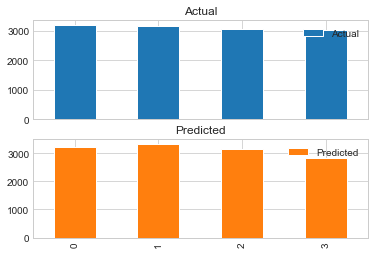

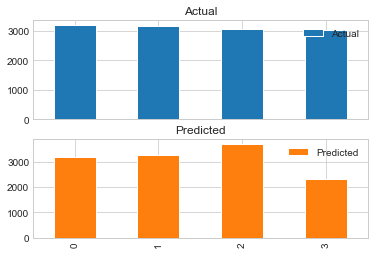

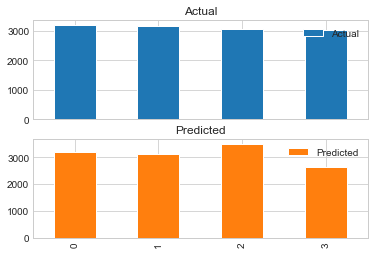

In [39]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim =1
    else:
        trainX_data = combination_features_X 
        dim = 2
    result = compute_MLP_Classifier(flag=1,dim=dim,trainX_data=trainX_data,trainY_data=train_Y.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler(),verbose=1)
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - Validation_split

Train on 8732 samples, validate on 3743 samples
Epoch 1/50
8732/8732 [==============================] - 2s 242us/step - loss: 6.3762 - accuracy: 0.3846 - val_loss: 10.9755 - val_accuracy: 0.1926
Epoch 2/50
8732/8732 [==============================] - 2s 246us/step - loss: 6.1091 - accuracy: 0.5376 - val_loss: 11.1375 - val_accuracy: 0.1913
Epoch 3/50
8732/8732 [==============================] - 2s 258us/step - loss: 5.9902 - accuracy: 0.5949 - val_loss: 11.7655 - val_accuracy: 0.1926
Epoch 4/50
8732/8732 [==============================] - 2s 249us/step - loss: 5.9573 - accuracy: 0.6097 - val_loss: 10.0740 - val_accuracy: 0.1926
Epoch 5/50
8732/8732 [==============================] - 2s 215us/step - loss: 5.9060 - accuracy: 0.6293 - val_loss: 11.6849 - val_accuracy: 0.1926
Epoch 6/50
8732/8732 [==============================] - 2s 208us/step - loss: 4.2092 - accuracy: 0.6627 - val_loss: 10.2563 - val_accuracy: 0.1926
Epoch 7/50
8732/8732 [==============================] - 2s 246us/step 

<Figure size 864x432 with 0 Axes>

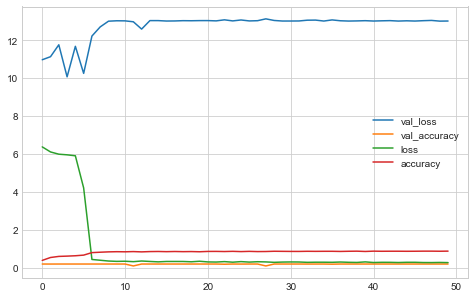

12475/12475 [==============================] - 0s 24us/step


[4.158853012638119, 0.6312625408172607]

In [40]:
model = create_model(dim=2)
history = model.fit(combination_features_X,train_Y,validation_split=0.3,batch_size = 10,epochs=50,verbose=1)
plt.figure(figsize=(12,6))
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
model.evaluate(combination_features_X,train_Y,verbose=1)

#### Experiment -MLP with Stratified K-Fold
Experiment using cross validation approach of StratifiedKFold

Cross Validation Activated. CV = 2


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Activated. CV = 3


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Activated. CV = 4
Cross Validation Activated. CV = 5
Cross Validation Activated. CV = 2


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Activated. CV = 3


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Activated. CV = 4
Cross Validation Activated. CV = 5
Cross Validation Activated. CV = 2


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Activated. CV = 3


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Activated. CV = 4
Cross Validation Activated. CV = 5


,mae,mse,rmse,precision,accuracy,f1-score,folds,type
11,0.427255,0.427255,0.653647,0.572690,0.572745,0.569151,5,Both
3,0.454589,0.454589,0.674232,0.524838,0.545411,0.530011,5,RSSI Only
7,0.485371,0.485371,0.696686,0.516586,0.514629,0.511909,5,Rolling Mean RSSI
6,0.620281,0.620281,0.787579,0.383460,0.379719,0.378012,4,Rolling Mean RSSI
2,0.647776,0.647776,0.804845,0.374851,0.352224,0.357826,4,RSSI Only
1,0.684489,0.684489,0.827338,0.199710,0.315511,0.239594,3,RSSI Only
9,0.692024,0.692024,0.831880,0.198038,0.307976,0.236523,3,Both
5,0.703407,0.703407,0.838694,0.189499,0.296593,0.226730,3,Rolling Mean RSSI
10,0.875431,0.875431,0.935645,0.131443,0.124569,0.099267,4,Both
8,0.873667,0.873667,0.934702,0.049215,0.126333,0.066275,2,Both


Number of Folds:  5


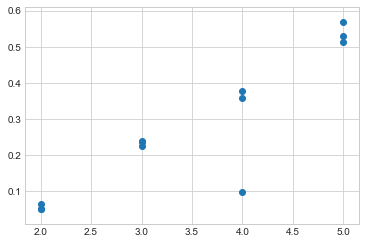

In [41]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X 
        dim = 2
    for cv in cross_validation_list:
        result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,testY_data=train_Y.ravel(),epochs=25,
                                   scaler=StandardScaler(),cross_validation=cv)
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['folds'],statistics['f1-score'])
selected_fold = statistics.sort_values(by=['f1-score'],ascending=False)['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - MLP with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size,type
22,0.151170,0.151170,0.388806,0.845853,0.848830,0.846106,0.5,Both
20,0.160299,0.160299,0.400374,0.842788,0.839701,0.839251,0.3,Both
18,0.167468,0.167468,0.409228,0.830576,0.832532,0.830210,0.1,Both
19,0.173146,0.173146,0.416109,0.829724,0.826854,0.826753,0.2,Both
21,0.180160,0.180160,0.424453,0.830424,0.819840,0.820785,0.4,Both
23,0.182766,0.182766,0.427511,0.839768,0.817234,0.811668,0.6,Both
24,0.199588,0.199588,0.446752,0.800027,0.800412,0.793299,0.7,Both
25,0.214930,0.214930,0.463605,0.778969,0.785070,0.780347,0.8,Both
2,0.221747,0.221747,0.470900,0.787244,0.778253,0.778807,0.3,RSSI Only
3,0.227856,0.227856,0.477342,0.784840,0.772144,0.773112,0.4,RSSI Only


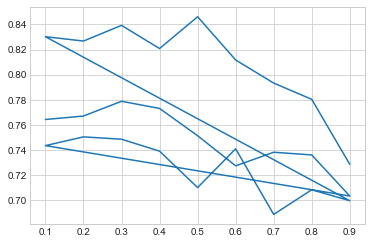

In [40]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=train_Y)
        result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### Experiment - MLP with LOGO
Experiment using cross validation approach of Leave One Group Out

In [41]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
    loo.append(scannedType)
    results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x000001C763ECE8C8>
Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x000001C7594149C8>
Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x000001C7654100C8>


,mae,mse,rmse,precision,accuracy,f1-score,type
0,1.0,1.0,1.0,0.0,0.0,0.0,RSSI Only
1,1.0,1.0,1.0,0.0,0.0,0.0,Rolling Mean RSSI
2,1.0,1.0,1.0,0.0,0.0,0.0,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using MLP

Epoch 1/25
8732/8732 [==============================] - 6s 723us/step - loss: 0.6083 - accuracy: 0.6863
Epoch 2/25
8732/8732 [==============================] - 5s 604us/step - loss: 0.5470 - accuracy: 0.7059
Epoch 3/25
8732/8732 [==============================] - 5s 561us/step - loss: 0.5377 - accuracy: 0.6909
Epoch 4/25
8732/8732 [==============================] - 5s 615us/step - loss: 0.5311 - accuracy: 0.6875
Epoch 5/25
8732/8732 [==============================] - 6s 685us/step - loss: 0.5249 - accuracy: 0.7016
Epoch 6/25
8732/8732 [==============================] - 6s 717us/step - loss: 0.5189 - accuracy: 0.7067
Epoch 7/25
8732/8732 [==============================] - 6s 670us/step - loss: 0.5097 - accuracy: 0.7132
Epoch 8/25
8732/8732 [==============================] - 9s 1ms/step - loss: 0.5034 - accuracy: 0.7217
Epoch 9/25
8732/8732 [==============================] - 8s 913us/step - loss: 0.4938 - accuracy: 0.7286
Epoch 10/25
8732/8732 [==============================] - 6s 730us/

,mae,mse,rmse,precision,accuracy,f1-score,method,type
7,0.163772,0.163772,0.404688,0.840620,0.836228,0.835985,HoldOut,Both
1,0.232701,0.232701,0.482391,0.777579,0.767299,0.767537,HoldOut,RSSI Only
4,0.237243,0.237243,0.487076,0.758940,0.762757,0.754448,HoldOut,Rolling Mean RSSI
8,0.429178,0.429178,0.655117,0.569795,0.570822,0.566792,Stratified K-Fold,Both
2,0.444489,0.444489,0.666700,0.532594,0.555511,0.538108,Stratified K-Fold,RSSI Only
5,0.485611,0.485611,0.696858,0.517504,0.514389,0.512345,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


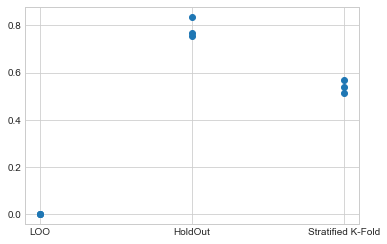

In [42]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
    holdout = compute_MLP_Classifier(verbose=1,dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited) 
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skfold = compute_MLP_Classifier(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = 5)  
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['method'],statistics['f1-score'],'o')
selected_method = statistics.sort_values(by=['f1-score'],ascending=False)['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
8,0.162169,0.162169,0.402703,0.840300,0.837831,0.837146,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
10,0.209992,0.209992,0.458249,0.792194,0.790008,0.786242,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
0,0.221747,0.221747,0.470900,0.787244,0.778253,0.778807,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
4,0.246594,0.246594,0.496582,0.748741,0.753406,0.745652,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
2,0.257280,0.257280,0.507228,0.737244,0.742720,0.738093,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
7,0.277852,0.277852,0.527117,0.704862,0.722148,0.705835,None,None,Rolling Mean RSSI
6,0.279722,0.279722,0.528888,0.712228,0.720278,0.703170,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
9,0.274913,0.274913,0.524322,0.723240,0.725087,0.696087,MaxAbsScaler,MaxAbsScaler(copy=True),Both
11,0.297889,0.297889,0.545792,0.700314,0.702111,0.692060,None,None,Both
5,0.279989,0.279989,0.529140,0.712485,0.720011,0.690549,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI


Selected Preprocessing:  StandardScaler


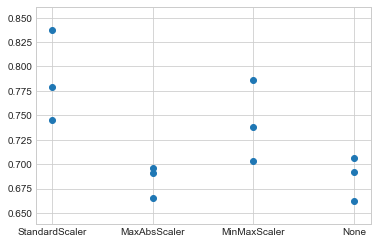

In [43]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited) 
        elif selected_method =='Stratified K-Fold':
            result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = 5)  
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['preprocessing'],statistics['f1-score'])
selected_preprocessing = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### Experiment - Hyperparameter Optimization (Number of neurons per Layer)

In [ ]:
statistical_cols = ['neurons','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim, epochs=15, batch_size=10, verbose=0)
    param_grid = dict(num_neurons=neurons)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['num_neurons'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_number_neurons = statistics.sort_values(by=['neurons'])['neurons'].head(1).values[0]
print("Selected Number Neurons: ",selected_number_neurons)

#### Experiment -  Hyperparameter Optimization (Batch Size and Epochs)

In [ ]:
statistical_cols = ['batch_size','epochs','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim, verbose=0)
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['batch_size'])
    result.append(grid_result.best_params_['epochs'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_batch_size = statistics.sort_values(by=['batch_size'])['batch_size'].head(1).values[0]
print("Selected Batch Size: ",selected_batch_size)
selected_epochs = statistics.sort_values(by=['epochs'])['epochs'].head(1).values[0]
print("Selected Epochs: ",selected_epochs)

#### Experiment -  Hyperparameter Optimization (Optimization Algorithm)

In [ ]:
statistical_cols = ['optimization_algorithm','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50, batch_size=10, verbose=0)
    param_grid = dict(optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['optimizer'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_optimization_algorithm = statistics.sort_values(by=['optimization_algorithm'])['optimization_algorithm'].head(1).values[0]
print("Selected Optimization Algorithm: ",selected_optimization_algorithm)

#### Experiment -  Hyperparameter Optimization (Learning Rate and Momentum)

In [ ]:
from keras.optimizers import SGD
def create_model_SGD(dim=2,learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(num_neurons_basic,input_dim=dim,activation='relu'))
    model.add(Dense(num_neurons_basic,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
statistical_cols = ['learning_rate','momentum','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model_SGD,dim=dim,epochs=50, batch_size=10, verbose=0)
    param_grid = dict(learn_rate=learn_rate, momentum=momentum)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['learn_rate'])
    result.append(grid_result.best_params_['momentum'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_learning_rate = statistics.sort_values(by=['learning_rate'])['learning_rate'].head(1).values[0]
print("Selected Learing Rate: ",selected_learning_rate)
selected_momentum = statistics.sort_values(by=['momentum'])['momentum'].head(1).values[0]
print("Selected Momentum: ",selected_momentum)

#### Experiment -  Hyperparameter Optimization (Activation Function)

In [ ]:
statistical_cols = ['activation_function','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50,batch_size=10,verbose=0)
    param_grid = dict(activation=activation)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['activation'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_activation_function = statistics.sort_values(by=['activation_function'])['activation_function'].head(1).values[0]
print("Selected Activation Function: ",selected_activation_function)

### Run RandomSearchCV for parameter tunning

In [ ]:
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50,batch_size=10,verbose=0)
    param_grid = dict(activation=activation,optimizer=optimizer,num_neurons=neurons)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_iter=50, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_)
    result.append(feature)
    results.append(result)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

### Best Parameters
Display the best parameters tunned throughout the experiments

In [ ]:
conclusion_cols=['Cross_Validation','Number of Neurons','Activation Function','Batch Size','Epochs','Optimizer','Learning Rate',
                 'Momentum','Preprocessing']
conclusion_list = [selected_method,selected_number_neurons,selected_activation_function,selected_batch_size,selected_epochs,
                   selected_optimization_algorithm,selected_learning_rate,selected_momentum,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

### Best Results
Compute MLP with the best parameters

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=selected_epochs,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                        num_neurons=selected_num_neurons,activation_func=selected_activation_function,
                                        batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm) 
        elif selected_method =='Stratified K-Fold':
            result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = 5.
                                           num_neurons=selected_num_neurons,activation_func=selected_activation_function,
                                        batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm)   
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler(),
                                           num_neurons=selected_num_neurons,activation_func=selected_activation_function,
                                        batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm) 
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

### Best Results - Testing data (using data recovered from Android 6.0 Asus ZENFONE Live)
Experiment with testing dataset

In [38]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = create_model()
display(model.summary())

Default number of neurons: 180
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180)               540       
_________________________________________________________________
dense_2 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 724       
Total params: 33,844
Trainable params: 33,844
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_num_neurons,activation_func=selected_activation_function,
                                        batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm)  
        else: 
            model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

### Best Results - Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71)
Experiment with testing dataset

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_my_device
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_my_device
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_my_device
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_num_neurons,activation_func=selected_activation_function,
                                        batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm)  
        else: 
            model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_my_device.ravel(), predicted)
        report = classification_report(test_Y_my_device.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_my_device.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_my_device.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))